**A beta-Poisson model for infectious disease transmission**

This notebook is designed to accompany the upcoming paper of the same title by Joe Hilton and Ian Hall. In the paper, we introduce a branching process model for infectious disease transmission whose offspring distribution is a beta-Poisson mixture distribution. We compare this model's performance as a description of transmission by fitting it to several examples of transmission tree data and comparing these fits to those obtained by the Poisson, geometric, negative binomial, and zero-inflated Poisson (ZIP) models. The code in this notebook includes functions which perform standard probability and likelihood calculations for this model, estimate maximum likelihood parameters, and estimate confidence intervals for these parameters using bootstrapping. We provide a rough outline of the model here, with full derivations left to the paper.

In [52]:
from __future__ import print_function
import math
import numpy as np
import random
import scipy as sp
from scipy import special as spsp
from scipy import sparse as sparse
from scipy import stats as stats
from scipy import optimize as opt
from scipy import interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import mpmath
import matplotlib as mpl
import matplotlib.cm as cm
import time
cmap = cm.hot

**Model description**

The beta-Poisson model describes the person-to-person spread of a pathogen in a population where contact behaviour is homogeneous but transmission behaviour varies from person to person. During their infectious period an infectious individual makes $n$ contacts, drawn from a Poisson distribution with mean $N$. For each case a transmission probability $p$ is chosen from a beta distribution with parameters $(\alpha_1,\alpha_2)$, so that the number of subsequent cases is drawn from a beta-binomial distribution with these parameters and $n$ trials. In our paper we demonstrate that the mean of the resulting distribution is given by
\begin{equation}
\lambda=N\frac{\alpha_1}{\alpha_1+\alpha_2},
\end{equation}
and that if we make the substitution $\Phi=\frac{\alpha_1+\alpha_2}{N}$ the probability mass function can be expressed as:
\begin{equation}
\begin{aligned}
P(x;\lambda,\Phi,N)=\frac{N^x}{\Gamma(x+1)}\frac{\Gamma(x+\Phi \lambda)\Gamma(\Phi N)}{\Gamma(\Phi \lambda)\Gamma(x+\Phi N)}M(x+\Phi \lambda,x+\Phi N,-N).
\end{aligned}
\end{equation}

We demonstrate in the paper that in the limit $N\to\infty$, the beta-Poisson distribution approximates a beta-gamma mixture, i.e. a negative binomial. We will use a slightly unusual parameterisation . The negative binomial with mean $\lambda$ is overdispersed, so that its variance can be expressed as $\lambda(1+\theta)$ for some $\theta>0$. We parameterise the negative binomial in terms of $\lambda$ and $\theta$ so that the pmf is given by
\begin{align}
P(x;\lambda,\theta)=\frac{\Gamma(x+\frac{\lambda}{\theta})}{\Gamma(x+1)\Gamma({\frac{\lambda}{\theta}})}\Bigg(\frac{1}{1+\theta}\Bigg)^{\frac{\lambda}{\theta}}\Bigg(\frac{\theta}{\theta+1}\Bigg)^x.
\end{align}
The negative binomial we obtain in the limit $N\to\infty$ has overdispersion $\theta=\Phi^{-1}$.

In [ ]:
def beta_poisson_pmf(x,lmbd,Phi,N):
    if type(x)==int:
        P=spsp.hyp1f1(x+Phi*lmbd,x+Phi*N,-N)
        for n in range(1,x+1): # This loop gives us the N^x/gamma(x+1 term)
            P=(N/n)*P
        for m in range(x): # This loop gives us the term with the two gamma functions in numerator and denominator
            P=((m+Phi*lmbd)/(m+Phi*N))*P
    else:
        P=[]
        for i in range(0,len(x)):
            p=spsp.hyp1f1(x[i]+Phi*lmbd,x[i]+Phi*N,-N)
            for n in range(1,x[i]+1): # This loop gives us the N^x/gamma(x+1 term)
                p=(N/n)*p
            for m in range(x[i]): # This loop gives us the term with the two gamma functions in numerator and denominator
                p=((m+Phi*lmbd)/(m+Phi*N))*p
            P=P+[p]
    return P

In [2]:
class beta_poisson_gen:
    
#    def __init__(self, lmbd, Phi, N):
#        self.lmbd = lmbd
#        self.Phi = Phi
#        self.N = N
    
    def pmf(self, x, lmbd, Phi, N):
        return np.exp(self.logpmf(x,lmbd,Phi,N))
    
    def logpmf(self,x,lmbd,Phi,N):
        if type(x)==int:
            log_p = (x*np.log(N) -
                     np.real(spsp.loggamma(x+1)) +
                     np.real(spsp.loggamma(Phi*N)) +
                     np.real(spsp.loggamma(x+Phi*lmbd)) -
                     np.real(spsp.loggamma(x+Phi*N)) -
                     np.real(spsp.loggamma(Phi*lmbd)))
            if x+phi*N<50:
                log_p += np.log(spsp.hyp1f1(x+Phi*lmbd,x+Phi*N,-N))
            else:
                log_p += np.log(float(mpmath.hyp1f1(x+Phi*lmbd,x+Phi*N,-N)))
        else:
            log_p = []
            for i in range(0,len(x)):
                log_pp = (x[i]*np.log(N)-np.real(spsp.loggamma(x[i]+1)) +
                    np.real(spsp.loggamma(Phi*N)) +
                    np.real(spsp.loggamma(x[i]+Phi*lmbd)) -
                    np.real(spsp.loggamma(x[i]+Phi*N)) -
                    np.real(spsp.loggamma(Phi*lmbd)))
                if x[i]+Phi*N<50:
                    log_pp += np.log(spsp.hyp1f1(x[i]+Phi*lmbd,x[i]+Phi*N,-N))
                else:
                    log_pp += np.log(float(mpmath.hyp1f1(x[i]+Phi*lmbd,x[i]+Phi*N,-N)))
                log_p = log_p + [log_pp]
        return log_p
    
    def pgf(self, s, lmbd, Phi, N):
        if np.size(np.asarray(s))==1:
            G=spsp.hyp1f1(lmbd*Phi,N*Phi,N*(s-1));
        else:
            G=[]
            for i in range(0,np.size(np.asarray(s))):
                G=G+[spsp.hyp1f1(lmbd*Phi,N*phi,N*(s[i]-1))]
        return G

    def extinction_prob(self, lmbd, phi, N ):
        if lmbd<=1:
            return 1
        else:
            def f(s):
                return beta_poisson_pgf(s,lmbd,phi,N)-s
            q=opt.brentq(
                f, 0, 1-1e-4);
            return q

beta_poisson = beta_poisson_gen()

In [3]:
print(beta_poisson_pmf([1,2,3,4],2,0.1,5))
print(beta_poisson.pmf([1,2,3,4],2,0.1,5))

NameError: name 'beta_poisson_pmf' is not defined

The next code block generates a widget with which you can plot the pmf of the beta-Poisson distribution and use a set of sliders to control the values of $\lambda$, $\Phi$, and $N$. You should find that when $\lambda$ is close to $N$ or $\Phi$ is large the distribution is more symmetrical, and that decreasing either $\lambda$ or $\Phi$ skews the distribution towards zero.

In [ ]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(lmbd,Phi,N):
    fig, ax=plt.subplots(figsize=(5,5))
    plt.figure(1)
    x = list(range(int(np.ceil(lmbd+4*np.sqrt(lmbd*(1+(N-lmbd)/(Phi*N+1)))))))
    P=beta_poisson_pmf(x,lmbd,Phi,N)
    plt.bar(x,P)
    plt.show()
    
lmbd_widget=widgets.FloatSlider(min=0.05,max=5,step=0.05,value=1)
Phi_widget=widgets.FloatSlider(min=0.01,max=2,step=0.01,value=0.2)
N_widget=widgets.FloatSlider(min=0.1,max=40,step=0.1,value=5)
def update_lmbd_range(*args):
    lmbd_widget.max=N_widget.value
N_widget.observe(update_lmbd_range,'value')
interactive_plot=interactive(f,lmbd=lmbd_widget,Phi=Phi_widget,N=N_widget)
ourput=interactive_plot.children[-1]
interactive_plot

**Likelihood calculations**

Suppose that we have a vector $(x_1,...,x_K)$ of secondary case data, i.e. $x_i$ is the number of cases which have case $i$ as their infector (note that in this work we do not address the problem of how to identify these infectors and so generate a dataset). The log-likelihood of parameters $(\lambda,\Phi,N)$ given this data is given by
\begin{align}
\log\mathcal{L}=\sum\limits_{i=1}^Kx_i\log N-\log\Gamma(x_i+1)+\log\Gamma(\Phi N)+\log\Gamma(x_i+\Phi \lambda)-\log\Gamma(x_i+\Phi N)-\log\Gamma(\Phi \lambda)+\log M(x_i+\Phi \lambda,x_i+\Phi N,-N).
\end{align}
For large values of $N$ this formula is numerically unstable, and in this region we will use the log likelihood function of the negative binomial distribution with $\theta=\Phi^{-1}$. One can justify the choice of $N=1,000$ as a cutoff by calculating the beta-Poisson and negative binomial probability mass functions up to a suitable maximum (x=250 seems a generous upper limit for secondary case data) and for a range of $\lambda$ and $\Phi$ values. In an emerging infection context we are interested in $\lambda$ up to about $2$ and, since $\Phi$ is inversely proportional to the level of overdisperion in the data, considering $\Phi$ values below ten is usually sufficient for fitting overdispersed datasets.

In the next code block, `beta_poisson_loglh` calculates the log likelihood of the beta-Poisson parameters $(\lambda,\Phi,N)$ given a set of count data, and `neg_bin_bp_loglh` the log likelihood of the negative binomial parameters $(\lambda,\Phi^{-1})$, or equivalently the beta-Poisson parameters $(\lambda,\Phi,\infty)$. For the purposes of this notebook it is useful for us to define separate functions calculating the negative binomial log likelihood in the $N\to\infty$ extreme of the beta-Poisson model, and as the likelihood function of the negative binomial model in its own right - hence the "`bp`" in the name of the function in the box immediately below.

In [4]:
def beta_poisson_loglh(data,lmbd,phi,N):
    return sum(beta_poisson.logpmf(data,lmbd,phi,N))

def neg_bin_bp_loglh(data,lmbd,phi):
    return sum(stats.nbinom.logpmf(data,lmbd*phi,phi/(phi+1)))

Given a vector of count data, we can calculate the maximum likelihood parameters numerically by finding the minimum of the likelihood function. This is a two-dimensional problem, since the MLE of $\lambda$ is just the sample mean. The maximum likelihood estimation is carried out in the function `get_phi_and_N_mles`. Because $N$ can theoretically range up to infinity but its MLE is bounded below by that of $\lambda$, we optimise over $\nu=\frac{1}{N}$ rather than $N$. For values of $\nu$ less than $10^{-3}$ (i.e. values of $N$ greater than $1,000$) the optimiser takes `neg_bin_bp_loglh` as the function to optimise over rather than `beta_poisson_loglh`.

In [5]:
def get_phi_and_N_mles(data,phi_0,N_0):
    def f(params):
        lmbd=np.mean(data)
        phi=params[0]
        if params[1]>0.1e-3:
            N=1/params[1]
            return -beta_poisson_loglh(data,lmbd,phi,N)
        else:
            return -neg_bin_bp_loglh(data,lmbd,phi)
    mle=sp.optimize.minimize(f,[phi_0,N_0],bounds=((1e-6,50),(0,1/np.mean(data))))
    if mle.x[1]<0:
        mle.x[1]=0
    return mle.x[0],mle.x[1]

In the supplementary material to the paper we show that the pgf of a beta-Poisson distributed random variable $X$ is
\begin{equation}
    G_X(s)=M(\lambda\Phi,N\Phi,N(s-1)).
\end{equation}
This is calculated using the function `beta_poisson_pgf`. From standard branching process theory, the extinction probability of a beta-Poisson epidemic is the solution to the equation
\begin{equation}
    q=G(q),
\end{equation}
and can be calculated using the function `beta_poisson_extinction_prob`.

These functions are not used to calculate any of the results presented in our paper, but are included here for completeness.

The functions in the following block carry out the equivalent calculations (log likelihood, maximum likelihood estimates, pgf, and extinction probability) for the Poisson, geometric, negative binomial, and ZIP calculations.


The function `nbinom.pmf` in the `scipy.stats` package uses a parameterisation in terms of parameters $n$ and $p$. Under this parameterisation the mean and variance of the distribution are respectively given by $(1-p)n/p$ and $(1-p)n/p^2$. After some rearrangement, one can show that $n=\lambda/\theta$ and $p=1/(\theta+1)$, so that to calculate negative binomial probabilities (and likelihoods) in our $(\lambda,\theta)$ parameterisation we use `stats.nbinom.pmf(x,lmbd/theta,1/(theta+1))`.

In [6]:
def poisson_loglh(data,lmbd):
    return sum(stats.poisson.logpmf(data,lmbd))
        
def geo_loglh(data,lmbd):
    return sum(stats.geom.logpmf(data,1/(lmbd+1),-1))

def neg_bin_loglh(data,lmbd,theta):
    return sum(stats.nbinom.logpmf(data,lmbd/theta,1/(theta+1)))

def get_theta_mle(data,theta_0):
    def f(theta):
        lmbd=np.mean(data)
        return -neg_bin_loglh(data,lmbd,theta)
    mle=sp.optimize.minimize(f,[theta_0],bounds=((1e-6,50),))
    return mle.x[0]

def zip_pmf(x,lmbd,sigma):
    if type(x)==int:
        return sigma*(x==0)+(1-sigma)*stats.poisson.pmf(x,lmbd)
    else:
        return sigma*np.equal(x,np.zeros(len(x)))+(1-sigma)*stats.poisson.pmf(x,lmbd)

def zip_loglh(data,lmbd,sigma):
    llh=0
    for x in data:
        if x==0:
            llh+=np.log(sigma+(1-sigma)*np.exp(-lmbd))
        else:
            llh+=np.log(1-sigma)+np.log(stats.poisson.pmf(x,lmbd))
    return llh

def get_zip_mles(data,lmbd_0,sigma_0):
    def f(params):
        lmbd=params[0]
        sigma=params[1]
        return -zip_loglh(data,lmbd,sigma)
    mle=sp.optimize.minimize(f,[lmbd_0,sigma_0],bounds=((np.mean(data),50),(0,1-1e-6)))
    return mle.x[0],mle.x[1]

**Fits to transmission chain data**

In our paper we study the fitting behaviour of the beta-Poisson model by fitting it (and our other models of interest) to eight transmission chain datasets. We estimate maximum likelihood parameters and calculate the Akaike Information Criterion (AIC) for each fitted model. In the next cell we define a class whose objects contain the parameter fits, log likelihoods, and AICs of each model for a given dataset.

In [7]:
class trans_chain_mles:
    def __init__(self,
                data):
        
        self.data = data
        self.mean = np.mean(data)
        self.var = np.var(data)
        
        theta_mle = get_theta_mle(data, self.mean)
        
        lmbd_mle, sigma_mle = get_zip_mles(data, self.mean, 0.5)
        
        phi_mle, Nu_mle=get_phi_and_N_mles(data, 1, 1/max(data))
        
        if Nu_mle>1e-3:
            beta_poi_var = self.mean * (1 + (1 - self.mean*Nu_mle)/(phi_mle + Nu_mle))
        else:
            beta_poi_var = self.mean * (1 + 1/phi_mle)
        
        poisson_llh = poisson_loglh(data, self.mean)
        geometric_llh = geo_loglh(data, self.mean)
        neg_bin_llh = neg_bin_loglh(data, self.mean, theta_mle)
        zip_llh = zip_loglh(data, lmbd_mle, sigma_mle)
        
        if Nu_mle>1e-3:
            beta_poi_llh = beta_poisson_loglh(data, self.mean, phi_mle, 1/Nu_mle)
        else:
            beta_poi_llh = neg_bin_loglh(data, self.mean, theta_mle)
        
        self.poisson = {'lambda' : self.mean,
                        'mean' : self.mean,
                        'var' : self.mean,
                        'llh' : poisson_llh,
                        'AIC' : 2 - 2*poisson_llh}
        
        self.geometric = {'lambda' : self.mean,
                          'mean' : self.mean,
                          'var' : self.mean * (1+self.mean),
                          'llh' : geometric_llh,
                          'AIC' : 2 - 2*geometric_llh}
        
        self.neg_bin = {'lambda' : self.mean,
                        'theta' : theta_mle,
                        'mean' : self.mean,
                        'var' : self.mean * (1+theta_mle),
                        'llh' : neg_bin_llh,
                        'AIC' : 4 - 2*neg_bin_llh}
        
        self.zip = {'lambda' : lmbd_mle,
                    'sigma' : sigma_mle,
                    'mean' : lmbd_mle * (1-sigma_mle),
                    'var' : lmbd_mle * (1-sigma_mle) * (1+lmbd_mle*sigma_mle),
                    'llh' : zip_llh,
                    'AIC' : 4 - 2*zip_llh}
        
        self.beta_poi = {'lambda' : self.mean,
                         'Phi' : phi_mle,
                         'Nu' : Nu_mle,
                         'mean' : self.mean,
                         'var' : beta_poi_var,
                         'llh' : beta_poi_llh,
                         'AIC' : 6 - 2*beta_poi_llh}
        
        

The next cell introduces a function which plots the empirical and fitted secondary case distributions.

In [17]:
def plot_chain_data_fits(fits, ax, title, fs=20):
    
    xVals = range(max(fits.data)+1)

    counts, bins = np.histogram(fits.data, max(fits.data)+1)
    dist = counts / len(fits.data)

    ax.plot(np.where(dist>0)[0], dist[dist>0], 'x', markersize=20)

    poi_line = stats.poisson.pmf(xVals, fits.poisson['lambda'])
    ax.plot(xVals, poi_line, lw=3)

    geom_line = stats.geom.pmf(xVals, 1/(fits.geometric['lambda']+1),-1)
    ax.plot(xVals, geom_line, lw=3)

    neg_bin_line = stats.nbinom.pmf(xVals,
                                  fits.neg_bin['lambda']/fits.neg_bin['theta'],
                                  1/(fits.neg_bin['theta']+1))
    ax.plot(xVals, neg_bin_line, lw=3)

    zip_line = zip_pmf(xVals, fits.zip['lambda'], fits.zip['sigma'])
    ax.plot(xVals, zip_line, lw=3)

    if fits.beta_poi['Nu']>1e-3:
        beta_poi_line = beta_poisson.pmf(xVals,
                                         fits.beta_poi['lambda'],
                                         fits.beta_poi['Phi'],
                                         1/fits.beta_poi['Nu'])
        ax.plot(xVals, beta_poi_line, lw=3)
    else:
        beta_poi_line = neg_bin_line

    ax.axis([-0.5, max(fits.data)+0.5, 0, 1])

    ax.set_aspect((max(fits.data)+1))

    ax.set_xlabel('Secondary cases', fontsize=fs)
    ax.set_ylabel('Probability', fontsize=fs)
    ax.set_title(title, fontsize=fs)

In the following cell we define another plotting function, this one plotting the beta distribution which defines the individual-level variation in infectivity.

In [9]:
def plot_underlying_beta(fits):
    
    x = np.linspace(1e-2,1, 100)
    y = stats.beta.pdf(x,
                       fits.beta_poi['lambda'] * fits.beta_poi['Phi'],
                       (1/fits.beta_poi['Nu'] - fits.beta_poi['lambda']) * fits.beta_poi['Phi'])
    
    fig,ax = plt.subplots(figsize=(10,10))
    
    plt.plot(x, y,'r-', lw=5, alpha=0.6, label='beta pdf')
    
    ax.axis([-0.01, 1.01, 0, 1.01*np.max(y)])
    
    ax.set_aspect(1.02/(1.01*np.max(y)))
    
    plt.xlabel('Transmission probability',fontsize=25)
    
    plt.ylabel('PDF',fontsize=25)
    
    plt.xticks(fontsize=25)
    
    plt.yticks(fontsize=25)
    
    plt.show()

**Starting example: Plague**<br/>
From [Gani and Leach 2004](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3323083/pdf/03-0509.pdf).

To begin with, we calculate the maximum likelihood parameters and associated AIC for each model:

In [10]:
gani_data = [0]*16+[1]*10+[2]*7+[3]*2+[4]*3+[5]+[6]

gani_fits = trans_chain_mles(gani_data)

np.set_printoptions(precision=3)
print('Distribution          | Lambda | Theta | Sigma |Nu=1/N |  Phi  | Log Likelihood |   AIC  |')
print('__________________________________________________________________________________________')
print('Poisson               |', "%.3f"% gani_fits.poisson['lambda'],' |       |       |       |       |   ', "%.3f"% gani_fits.poisson['llh'],'    |', "%.3f"% gani_fits.poisson['AIC'])
print('Geometric             |', "%.3f"% gani_fits.geometric['lambda'],' |       |       |       |       |   ', "%.3f"% gani_fits.geometric['llh'],'    |', "%.3f"% gani_fits.geometric['AIC'])
print('Negative binomial     |', "%.3f"% gani_fits.neg_bin['lambda'],' |', "%.3f"% gani_fits.neg_bin['theta'],'|       |       |       |   ', "%.3f"% gani_fits.neg_bin['llh'],'    |', "%.3f"% gani_fits.neg_bin['AIC'])
print('Zero-inflated Poisson |', "%.3f"% gani_fits.zip['lambda'],' |       |', "%.3f"% gani_fits.zip['sigma'],'|       |       |   ', "%.3f"% gani_fits.zip['llh'],'    |', "%.3f"% gani_fits.zip['AIC'])
print('Beta Poisson          |', "%.3f"% gani_fits.beta_poi['lambda'],' |       |       |', "%.3f"% gani_fits.beta_poi['Nu'],'|', "%.3f"% gani_fits.beta_poi['Phi'],'|   ', "%.3f"% gani_fits.beta_poi['llh'],'    |', "%.3f"% gani_fits.beta_poi['AIC'])

Distribution          | Lambda | Theta | Sigma |Nu=1/N |  Phi  | Log Likelihood |   AIC  |
__________________________________________________________________________________________
Poisson               | 1.325  |       |       |       |       |    -67.422     | 136.843
Geometric             | 1.325  |       |       |       |       |    -63.551     | 129.102
Negative binomial     | 1.325  | 0.923 |       |       |       |    -63.312     | 130.624
Zero-inflated Poisson | 1.867  |       | 0.290 |       |       |    -63.945     | 131.890
Beta Poisson          | 1.325  |       |       | 0.248 | 0.583 |    -63.120     | 132.240


Plotting the data and fitted models demonstrates that the Poisson fails to capture the high incidence of zeros in the data:

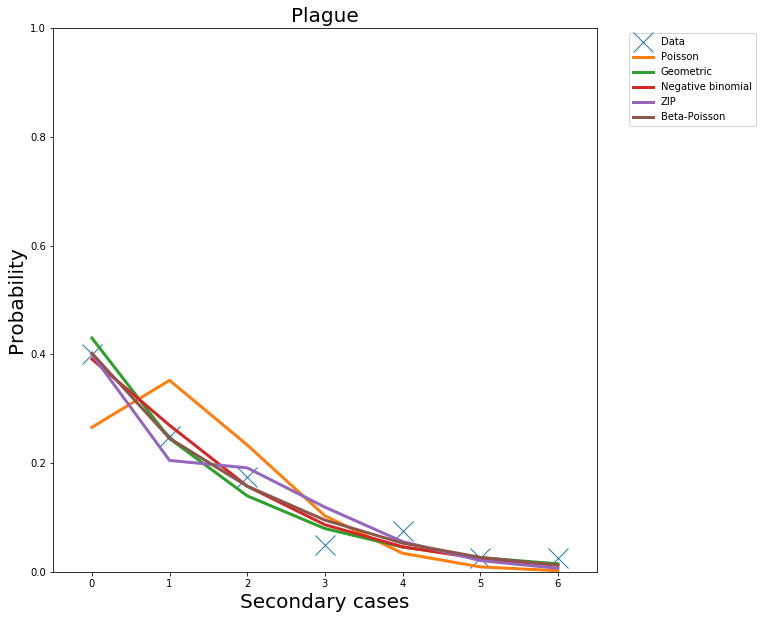

In [18]:
fig, ax = plt.subplots(figsize=(10,10))

plot_chain_data_fits(gani_fits, ax, 'Plague')

ax.legend(['Data','Poisson','Geometric','Negative binomial','ZIP','Beta-Poisson'],
          bbox_to_anchor=(1.05,1),
          loc='upper left')

plt.show()

We can also visualise the distribution of infectivity across cases in the fitted beta-Poisson by plotting the underlying beta distribution:

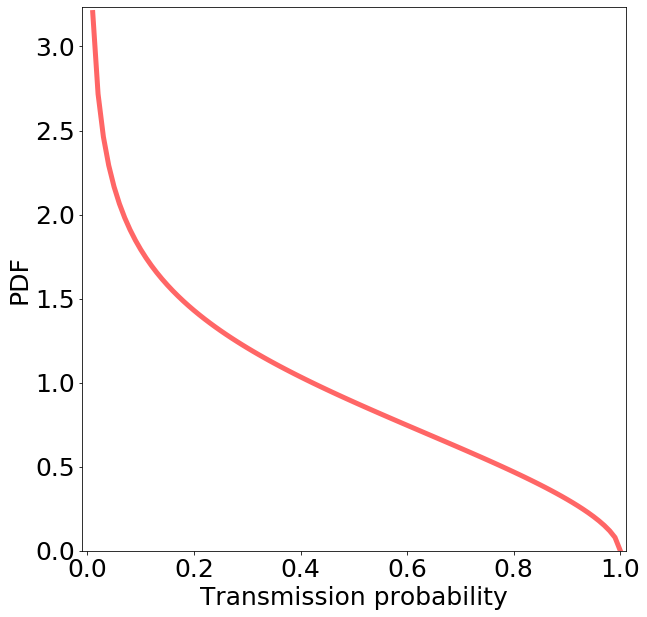

In [12]:
plot_underlying_beta(gani_fits)

The fitting behaviour of the beta-Poisson model can be visualised by calculating thelikelihood function of each parameter with the other two fixed at their MLEs. The slow decay of the likelihood function associated with increasing values of $\Phi$ is consistent with the relatively high likelihood assigned to the Poisson distribution, which means that models with very low levels of overdispersion (i.e. large values of $\Phi$) can give a good fit.

In [ ]:
true_lmbd,true_phi,true_N=np.mean(current_data),phi_mle,1/N_inv_mle
data=current_data
lmbd_lh_array=beta_poisson_loglh(data,np.linspace(0.01,5,500),true_phi,true_N)
phi_lh_array=np.zeros(1000)
for i in range(1000):
    phi_lh_array[i]=beta_poisson_loglh(data,true_lmbd,(i+1)*1e-2,true_N)
n_lh_array=np.zeros(750)
n_lh_array[0]=neg_bin_bp_loglh(data,true_lmbd,true_phi)
for i in range(1,750):
    n_lh_array[i]=beta_poisson_loglh(data,true_lmbd,true_phi,1/(i/1000))

fig,ax=plt.subplots(figsize=(8,8))
ax.plot(np.linspace(0.01,5,500),lmbd_lh_array,'k',linewidth=6)
ax.plot([true_lmbd,true_lmbd],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\lambda$',fontsize=40)
plt.ylabel('Log likelihood',fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.show()

fig,ax=plt.subplots(figsize=(8,8))
ax.plot(np.linspace(0.01,10,1000),phi_lh_array,'k',linewidth=6)
ax.plot([true_phi,true_phi],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\Phi$',fontsize=40)
plt.ylabel('Log likelihood',fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.show()

fig,ax=plt.subplots(figsize=(8,8))
ax.plot(np.linspace(0.0,0.749,750),n_lh_array,'k',linewidth=6)
ax.plot([1/true_N,1/true_N],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\\nu$',fontsize=40)
plt.ylabel('Log likelihood',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.show()

## More datasets

In the cell below we define some more datasets and fit maximum likelihood parameters to each of them for each model.

In [13]:
jezek_data_g1=[0]*114+[1]*23+[2]*8+[3]*1+[5]*1 # First generation cases
jezek_data_g2=[0]*38+[1]*7+[2]*1+[3]*1 # Second generation cases
jezek_data_g3=[0]*9+[1]+[2]
jezek_data_g4=[0]*2+[1]
jezek_data=jezek_data_g1+jezek_data_g2+jezek_data_g3+jezek_data_g4

faye_data=[1,2,2,5,14,1,4,4,1,3,3,8,2,1,1,4,9,9,1,1,17,2,1,1,1,4,3,3,4,2,5,1,2,2,1,9,1,3,1,2,1,1,2]
faye_data=faye_data+[0]*(152-len(faye_data))
fasina_data=[0]*15+[1]*2+[2]+[3]+[12]
leo_data=[0]*162+[1]*19+[2]*8+[3]*7+[7]+[12]+[21]+[23]+[40]
cowling_data=[38,3,2,1,6,81,2,23,2,1,1,1,5,1,1,1,2,1,1,1]
cowling_data=cowling_data+[0]*(166-len(cowling_data))
chowell_data=[0]*13+[1]*5+[2]*4+[3]+[7]
heijne_data=[0]*22+[1]*13+[2]*6+[3]*3+[4]+[5]

jezek_fits = trans_chain_mles(jezek_data)
faye_fits = trans_chain_mles(faye_data)
fasina_fits = trans_chain_mles(fasina_data)
leo_fits = trans_chain_mles(leo_data)
cowling_fits = trans_chain_mles(cowling_data)
chowell_fits = trans_chain_mles(chowell_data)
heijne_fits = trans_chain_mles(heijne_data)

In [14]:
print('Dataset | Empirical |      Poisson      |     Geometric      |  Negative binomial  |        ZIP        | Beta-Poisson ')
print('Gani    | (',"%.3f"% gani_fits.mean,',',"%.3f"% gani_fits.var,') | (',"%.3f"% gani_fits.poisson['mean'],',',"%.3f"% gani_fits.poisson['var'],') | (',"%.3f"% gani_fits.geometric['mean'],',',"%.3f"% gani_fits.geometric['var'],')  |  (',"%.3f"% gani_fits.neg_bin['mean'],',',"%.3f"% gani_fits.neg_bin['var'],')  | (',"%.3f"% gani_fits.zip['mean'],',',"%.3f"% gani_fits.zip['var'],') | (',"%.3f"% gani_fits.beta_poi['mean'],',',"%.3f"% gani_fits.beta_poi['var'],') ')
print('Jezek   | (',"%.3f"% jezek_fits.mean,',',"%.3f"% jezek_fits.var,') | (',"%.3f"% jezek_fits.poisson['mean'],',',"%.3f"% jezek_fits.poisson['var'],') | (',"%.3f"% jezek_fits.geometric['mean'],',',"%.3f"% jezek_fits.geometric['var'],')  |  (',"%.3f"% jezek_fits.neg_bin['mean'],',',"%.3f"% jezek_fits.neg_bin['var'],')  | (',"%.3f"% jezek_fits.zip['mean'],',',"%.3f"% jezek_fits.zip['var'],') | (',"%.3f"% jezek_fits.beta_poi['mean'],',',"%.3f"% jezek_fits.beta_poi['var'],') ')
print('Faye    | (',"%.3f"% faye_fits.mean,',',"%.3f"% faye_fits.var,') | (',"%.3f"% faye_fits.poisson['mean'],',',"%.3f"% faye_fits.poisson['var'],') | (',"%.3f"% faye_fits.geometric['mean'],',',"%.3f"% faye_fits.geometric['var'],')  |  (',"%.3f"% faye_fits.neg_bin['mean'],',',"%.3f"% faye_fits.neg_bin['var'],')  | (',"%.3f"% faye_fits.zip['mean'],',',"%.3f"% faye_fits.zip['var'],') | (',"%.3f"% faye_fits.beta_poi['mean'],',',"%.3f"% faye_fits.beta_poi['var'],') ')
print('Fasina  | (',"%.3f"% fasina_fits.mean,',',"%.3f"% fasina_fits.var,') | (',"%.3f"% fasina_fits.poisson['mean'],',',"%.3f"% fasina_fits.poisson['var'],') | (',"%.3f"% fasina_fits.geometric['mean'],',',"%.3f"% fasina_fits.geometric['var'],')  |  (',"%.3f"% fasina_fits.neg_bin['mean'],',',"%.3f"% fasina_fits.neg_bin['var'],')  | (',"%.3f"% fasina_fits.zip['mean'],',',"%.3f"% fasina_fits.zip['var'],') | (',"%.3f"% fasina_fits.beta_poi['mean'],',',"%.3f"% fasina_fits.beta_poi['var'],') ')
print('Leo     | (',"%.3f"% leo_fits.mean,',',"%.3f"% leo_fits.var,') | (',"%.3f"% leo_fits.poisson['mean'],',',"%.3f"% leo_fits.poisson['var'],') | (',"%.3f"% leo_fits.geometric['mean'],',',"%.3f"% leo_fits.geometric['var'],')  |  (',"%.3f"% leo_fits.neg_bin['mean'],',',"%.3f"% leo_fits.neg_bin['var'],')  | (',"%.3f"% leo_fits.zip['mean'],',',"%.3f"% leo_fits.zip['var'],') | (',"%.3f"% leo_fits.beta_poi['mean'],',',"%.3f"% leo_fits.beta_poi['var'],') ')
print('Cowling | (',"%.3f"% cowling_fits.mean,',',"%.3f"% cowling_fits.var,') | (',"%.3f"% cowling_fits.poisson['mean'],',',"%.3f"% cowling_fits.poisson['var'],') | (',"%.3f"% cowling_fits.geometric['mean'],',',"%.3f"% cowling_fits.geometric['var'],') | (',"%.3f"% cowling_fits.neg_bin['mean'],',',"%.3f"% cowling_fits.neg_bin['var'],') | (',"%.3f"% cowling_fits.zip['mean'],',',"%.3f"% cowling_fits.zip['var'],') | (',"%.3f"% cowling_fits.beta_poi['mean'],',',"%.3f"% cowling_fits.beta_poi['var'],') ')
print('Chowell | (',"%.3f"% chowell_fits.mean,',',"%.3f"% chowell_fits.var,') | (',"%.3f"% chowell_fits.poisson['mean'],',',"%.3f"% chowell_fits.poisson['var'],') | (',"%.3f"% chowell_fits.geometric['mean'],',',"%.3f"% chowell_fits.geometric['var'],')  |  (',"%.3f"% chowell_fits.neg_bin['mean'],',',"%.3f"% chowell_fits.neg_bin['var'],')  | (',"%.3f"% chowell_fits.zip['mean'],',',"%.3f"% chowell_fits.zip['var'],') | (',"%.3f"% chowell_fits.beta_poi['mean'],',',"%.3f"% chowell_fits.beta_poi['var'],') ')
print('Heijne  | (',"%.3f"% heijne_fits.mean,',',"%.3f"% heijne_fits.var,') | (',"%.3f"% heijne_fits.poisson['mean'],',',"%.3f"% heijne_fits.poisson['var'],') | (',"%.3f"% heijne_fits.geometric['mean'],',',"%.3f"% heijne_fits.geometric['var'],')  |  (',"%.3f"% heijne_fits.neg_bin['mean'],',',"%.3f"% heijne_fits.neg_bin['var'],')  | (',"%.3f"% heijne_fits.zip['mean'],',',"%.3f"% heijne_fits.zip['var'],') | (',"%.3f"% heijne_fits.beta_poi['mean'],',',"%.3f"% heijne_fits.beta_poi['var'],') ')

Dataset | Empirical |      Poisson      |     Geometric      |  Negative binomial  |        ZIP        | Beta-Poisson 
Gani    | ( 1.325 , 2.369 ) | ( 1.325 , 1.325 ) | ( 1.325 , 3.081 )  |  ( 1.325 , 2.548 )  | ( 1.325 , 2.043 ) | ( 1.325 , 2.396 ) 
Jezek   | ( 0.303 , 0.461 ) | ( 0.303 , 0.303 ) | ( 0.303 , 0.395 )  |  ( 0.303 , 0.460 )  | ( 0.303 , 0.428 ) | ( 0.303 , 0.460 ) 
Faye    | ( 0.954 , 5.794 ) | ( 0.954 , 0.954 ) | ( 0.954 , 1.864 )  |  ( 0.954 , 5.968 )  | ( 0.954 , 3.135 ) | ( 0.954 , 5.713 ) 
Fasina  | ( 0.950 , 7.048 ) | ( 0.950 , 0.950 ) | ( 0.950 , 1.852 )  |  ( 0.950 , 7.495 )  | ( 0.950 , 3.569 ) | ( 0.950 , 6.306 ) 
Leo     | ( 0.791 , 13.688 ) | ( 0.791 , 0.791 ) | ( 0.791 , 1.417 )  |  ( 0.791 , 7.516 )  | ( 0.791 , 3.331 ) | ( 0.791 , 7.516 ) 
Cowling | ( 1.048 , 50.889 ) | ( 1.048 , 1.048 ) | ( 1.048 , 2.147 ) | ( 1.048 , 30.586 ) | ( 1.048 , 9.067 ) | ( 1.048 , 30.591 ) 
Chowell | ( 0.958 , 2.373 ) | ( 0.958 , 0.958 ) | ( 0.958 , 1.877 )  |  ( 0.958 , 2.236 

In [ ]:
print('Dataset & Empirical & Poisson & Geometric & Negative binomial & ZIP & Beta-Poisson \')
print(' & Mean & Variance & Mean & Variance & Mean & Variance & Mean & Variance & Mean & Variance & Mean & Variance \')
print('Gani & ',"%.3f"% gani_fits.mean,'&',"%.3f"% gani_fits.var,' & ',"%.3f"% gani_fits.poisson['mean'],' & ',"%.3f"% gani_fits.poisson['var'],' & ',"%.3f"% gani_fits.geometric['mean'],' & ',"%.3f"% gani_fits.geometric['var'],' & ',"%.3f"% gani_fits.neg_bin['mean'],' & ',"%.3f"% gani_fits.neg_bin['var'],' & ',"%.3f"% gani_fits.zip['mean'],' & ',"%.3f"% gani_fits.zip['var'],' & ',"%.3f"% gani_fits.beta_poi['mean'],' & ',"%.3f"% gani_fits.beta_poi['var'],' \')
print('Jezek & ',"%.3f"% jezek_fits.mean,' & ',"%.3f"% jezek_fits.var,' & ',"%.3f"% jezek_fits.poisson['mean'],' & ',"%.3f"% jezek_fits.poisson['var'],' & ',"%.3f"% jezek_fits.geometric['mean'],' & ',"%.3f"% jezek_fits.geometric['var'],' & ',"%.3f"% jezek_fits.neg_bin['mean'],' & ',"%.3f"% jezek_fits.neg_bin['var'],' & ',"%.3f"% jezek_fits.zip['mean'],' & ',"%.3f"% jezek_fits.zip['var'],' & ',"%.3f"% jezek_fits.beta_poi['mean'],' & ',"%.3f"% jezek_fits.beta_poi['var'],' \')
print('Faye & ',"%.3f"% faye_fits.mean,' & ',"%.3f"% faye_fits.var,' & ',"%.3f"% faye_fits.poisson['mean'],' & ',"%.3f"% faye_fits.poisson['var'],' & ',"%.3f"% faye_fits.geometric['mean'],' & ',"%.3f"% faye_fits.geometric['var'],' & ',"%.3f"% faye_fits.neg_bin['mean'],' & ',"%.3f"% faye_fits.neg_bin['var'],' & ',"%.3f"% faye_fits.zip['mean'],' & ',"%.3f"% faye_fits.zip['var'],' & ',"%.3f"% faye_fits.beta_poi['mean'],' & ',"%.3f"% faye_fits.beta_poi['var'],' \')
print('Fasina & ',"%.3f"% fasina_fits.mean,' & ',"%.3f"% fasina_fits.var,' & ',"%.3f"% fasina_fits.poisson['mean'],' & ',"%.3f"% fasina_fits.poisson['var'],' & ',"%.3f"% fasina_fits.geometric['mean'],' & ',"%.3f"% fasina_fits.geometric['var'],' & ',"%.3f"% fasina_fits.neg_bin['mean'],' & ',"%.3f"% fasina_fits.neg_bin['var'],' & ',"%.3f"% fasina_fits.zip['mean'],' & ',"%.3f"% fasina_fits.zip['var'],' & ',"%.3f"% fasina_fits.beta_poi['mean'],' & ',"%.3f"% fasina_fits.beta_poi['var'],' \')
print('Leo & ',"%.3f"% leo_fits.mean,' & ',"%.3f"% leo_fits.var,' & ',"%.3f"% leo_fits.poisson['mean'],' & ',"%.3f"% leo_fits.poisson['var'],' & ',"%.3f"% leo_fits.geometric['mean'],' & ',"%.3f"% leo_fits.geometric['var'],' & ',"%.3f"% leo_fits.neg_bin['mean'],',',"%.3f"% leo_fits.neg_bin['var'],' & ',"%.3f"% leo_fits.zip['mean'],',',"%.3f"% leo_fits.zip['var'],' & ',"%.3f"% leo_fits.beta_poi['mean'],' & ',"%.3f"% leo_fits.beta_poi['var'],' \')
print('Cowling & ',"%.3f"% cowling_fits.mean,' & ',"%.3f"% cowling_fits.var,' & ',"%.3f"% cowling_fits.poisson['mean'],' & ',"%.3f"% cowling_fits.poisson['var'],' & ',"%.3f"% cowling_fits.geometric['mean'],' & ',"%.3f"% cowling_fits.geometric['var'],' & ',"%.3f"% cowling_fits.neg_bin['mean'],' & ',"%.3f"% cowling_fits.neg_bin['var'],' & ',"%.3f"% cowling_fits.zip['mean'],' & ',"%.3f"% cowling_fits.zip['var'],' & ',"%.3f"% cowling_fits.beta_poi['mean'],' & ',"%.3f"% cowling_fits.beta_poi['var'],' \')
print('Chowell & ',"%.3f"% chowell_fits.mean,' & ',"%.3f"% chowell_fits.var,' & ',"%.3f"% chowell_fits.poisson['mean'],' & ',"%.3f"% chowell_fits.poisson['var'],' & ',"%.3f"% chowell_fits.geometric['mean'],' & ',"%.3f"% chowell_fits.geometric['var'],' & ',"%.3f"% chowell_fits.neg_bin['mean'],' & ',"%.3f"% chowell_fits.neg_bin['var'],' & ',"%.3f"% chowell_fits.zip['mean'],' & ',"%.3f"% chowell_fits.zip['var'],' & ',"%.3f"% chowell_fits.beta_poi['mean'],' & ',"%.3f"% chowell_fits.beta_poi['var'],' \')
print('Heijne & ',"%.3f"% heijne_fits.mean,' & ',"%.3f"% heijne_fits.var,' & ',"%.3f"% heijne_fits.poisson['mean'],' & ',"%.3f"% heijne_fits.poisson['var'],' & ',"%.3f"% heijne_fits.geometric['mean'],' & ',"%.3f"% heijne_fits.geometric['var'],' & ',"%.3f"% heijne_fits.neg_bin['mean'],'v',"%.3f"% heijne_fits.neg_bin['var'],' & ',"%.3f"% heijne_fits.zip['mean'],' & ',"%.3f"% heijne_fits.zip['var'],' & ',"%.3f"% heijne_fits.beta_poi['mean'],' & ',"%.3f"% heijne_fits.beta_poi['var'],' \')

In [15]:
print('Dataset | Poisson | Geometric | Negative binomial ')
print('__________________________________________________')
print('Gani    | ',"%.3f"% np.exp(gani_fits.poisson['llh'] - gani_fits.beta_poi['llh']),' |  ',"%.3f"% np.exp(gani_fits.geometric['llh'] - gani_fits.beta_poi['llh']),'  |  ',"%.3f"% np.exp(gani_fits.neg_bin['llh'] - gani_fits.beta_poi['llh']))
print('Jezek   | ',"%.3f"% np.exp(jezek_fits.poisson['llh'] - jezek_fits.beta_poi['llh']),' |  ',"%.3f"% np.exp(jezek_fits.geometric['llh'] - jezek_fits.beta_poi['llh']),'  |  ',"%.3f"% np.exp(jezek_fits.neg_bin['llh'] - jezek_fits.beta_poi['llh']))
print('Faye    | ',"%.3f"% np.exp(faye_fits.poisson['llh'] - faye_fits.beta_poi['llh']),' |  ',"%.3f"% np.exp(faye_fits.geometric['llh'] - faye_fits.beta_poi['llh']),'  |  ',"%.3f"% np.exp(faye_fits.neg_bin['llh'] - faye_fits.beta_poi['llh']))
print('Fasina  | ',"%.3f"% np.exp(fasina_fits.poisson['llh'] - fasina_fits.beta_poi['llh']),' |  ',"%.3f"% np.exp(fasina_fits.geometric['llh'] - fasina_fits.beta_poi['llh']),'  |  ',"%.3f"% np.exp(fasina_fits.neg_bin['llh'] - fasina_fits.beta_poi['llh']))
print('Leo     | ',"%.3f"% np.exp(leo_fits.poisson['llh'] - leo_fits.beta_poi['llh']),' |  ',"%.3f"% np.exp(leo_fits.geometric['llh'] - leo_fits.beta_poi['llh']),'  |  ',"%.3f"% np.exp(leo_fits.neg_bin['llh'] - leo_fits.beta_poi['llh']))
print('Cowling | ',"%.3f"% np.exp(cowling_fits.poisson['llh'] - cowling_fits.beta_poi['llh']),' |  ',"%.3f"% np.exp(cowling_fits.geometric['llh'] - cowling_fits.beta_poi['llh']),'  |  ',"%.3f"% np.exp(cowling_fits.neg_bin['llh'] - cowling_fits.beta_poi['llh']))
print('Chowell | ',"%.3f"% np.exp(chowell_fits.poisson['llh'] - chowell_fits.beta_poi['llh']),' |  ',"%.3f"% np.exp(chowell_fits.geometric['llh'] - chowell_fits.beta_poi['llh']),'  |  ',"%.3f"% np.exp(chowell_fits.neg_bin['llh'] - chowell_fits.beta_poi['llh']))
print('Heijne  | ',"%.3f"% np.exp(heijne_fits.poisson['llh'] - heijne_fits.beta_poi['llh']),' |  ',"%.3f"% np.exp(heijne_fits.geometric['llh'] - heijne_fits.beta_poi['llh']),'  |  ',"%.3f"% np.exp(heijne_fits.neg_bin['llh'] - heijne_fits.beta_poi['llh']))

Dataset | Poisson | Geometric | Negative binomial 
__________________________________________________
Gani    |  0.014  |   0.650   |   0.826
Jezek   |  0.001  |   0.532   |   1.000
Faye    |  0.000  |   0.000   |   0.986
Fasina  |  0.000  |   0.005   |   0.978
Leo     |  0.000  |   0.000   |   1.000
Cowling |  0.000  |   0.000   |   1.000
Chowell |  0.010  |   0.886   |   1.000
Heijne  |  0.114  |   0.664   |   0.947


In [ ]:
print('Dataset | Nu')
print('____________________________')
print('Gani    |', "%.3f"% gani_fits.beta_poi['Nu'],'= 1 /',"%.3f"% (1/gani_fits.beta_poi['Nu']))
print('Jezek   |', "%.3f"% jezek_fits.beta_poi['Nu'],'= 1 /',"%.3f"% (1/jezek_fits.beta_poi['Nu']))
print('Faye    |', "%.3f"% faye_fits.beta_poi['Nu'],'= 1 /',"%.3f"% (1/faye_fits.beta_poi['Nu']))
print('Fasina  |', "%.3f"% fasina_fits.beta_poi['Nu'],'= 1 /',"%.3f"% (1/fasina_fits.beta_poi['Nu']))
print('Leo     |', "%.3f"% leo_fits.beta_poi['Nu'],'= 1 /',"%.3f"% (1/leo_fits.beta_poi['Nu']))
print('Cowling |', "%.3f"% cowling_fits.beta_poi['Nu'],'= 1 /',"%.3f"% (1/cowling_fits.beta_poi['Nu']))
print('Chowell |', "%.3f"% chowell_fits.beta_poi['Nu'],'= 1 /',"%.3f"% (1/chowell_fits.beta_poi['Nu']))
print('Heijne  |', "%.3f"% heijne_fits.beta_poi['Nu'],'= 1 /',"%.3f"% (1/heijne_fits.beta_poi['Nu']))

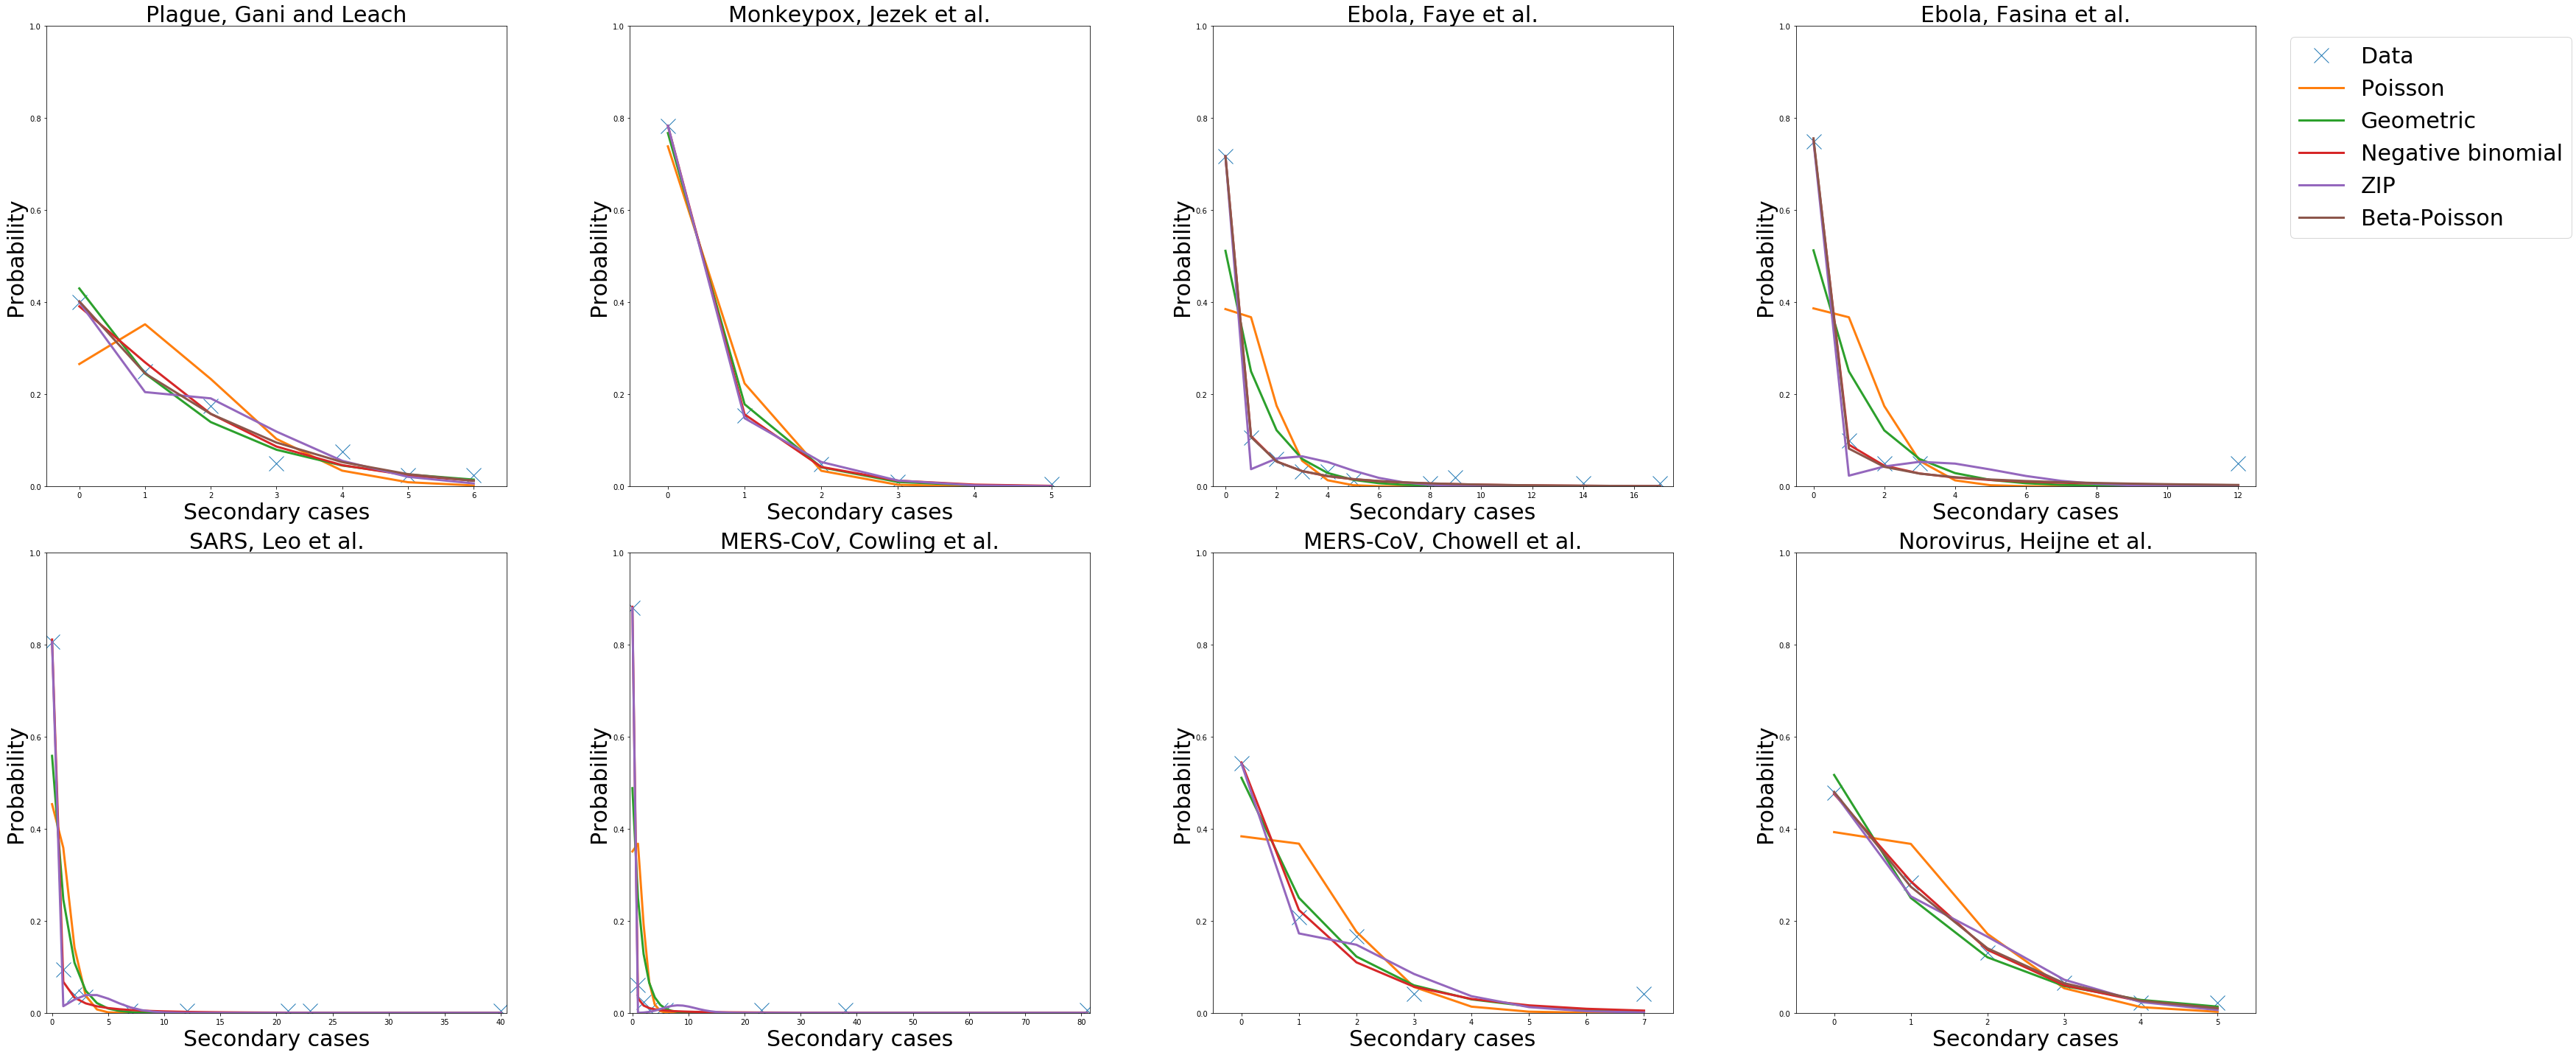

In [19]:
fig = plt.figure(figsize=(50,20))
gani_ax = plt.subplot2grid((2,4),(0,0))
jezek_ax = plt.subplot2grid((2,4),(0,1))
faye_ax = plt.subplot2grid((2,4),(0,2))
fasina_ax = plt.subplot2grid((2,4),(0,3))
leo_ax = plt.subplot2grid((2,4),(1,0))
cowling_ax = plt.subplot2grid((2,4),(1,1))
chowell_ax = plt.subplot2grid((2,4),(1,2))
heijne_ax = plt.subplot2grid((2,4),(1,3))

plot_chain_data_fits(gani_fits, gani_ax, 'Plague, Gani and Leach',30)
plot_chain_data_fits(jezek_fits, jezek_ax, 'Monkeypox, Jezek et al.',30)
plot_chain_data_fits(faye_fits, faye_ax, 'Ebola, Faye et al.',30)
plot_chain_data_fits(fasina_fits, fasina_ax, 'Ebola, Fasina et al.',30)
plot_chain_data_fits(leo_fits, leo_ax, 'SARS, Leo et al.',30)
plot_chain_data_fits(cowling_fits, cowling_ax, 'MERS-CoV, Cowling et al.',30)
plot_chain_data_fits(chowell_fits, chowell_ax, 'MERS-CoV, Chowell et al.',30)
plot_chain_data_fits(heijne_fits, heijne_ax, 'Norovirus, Heijne et al.',30)

fasina_ax.legend(['Data','Poisson','Geometric','Negative binomial','ZIP','Beta-Poisson'],
          bbox_to_anchor=(1.05,1),
          loc='upper left',
          fontsize=30)

plt.tight_layout()
plt.show()

## Confidence intervals

The bootstrap sampling used to calculate confidence intervals for the negative binomial and beta-Poisson models is very time consuming when large numbers of samples are used.

In [87]:
def poisson_confidence_intervals(data,interval,points):
    lmbd=np.linspace(interval[0],interval[1],points)
    llh=np.zeros(points)
    for x in data:
        llh += stats.poisson.logpmf(x,lmbd)
    mle_loc=np.argmax(llh)
    lh_normed=np.exp(llh)/np.sum(np.exp(llh))
    current_max=lh_normed[mle_loc]
    interval_weight=current_max
    while interval_weight<0.95:
        max_loc=np.argmax(lh_normed[np.where(lh_normed<current_max)])
        current_max=lh_normed[np.where(lh_normed<current_max)][max_loc]
        interval_weight+=current_max
    ci=[np.min(lmbd[np.where(lh_normed>=current_max)[0]]),np.max(lmbd[np.where(lh_normed>=current_max)[0]])]
    return ci

def geometric_confidence_intervals(data,interval,points):
    lmbd=np.linspace(interval[0],interval[1],points)
    llh=np.zeros(points)
    for x in data:
        llh += stats.geom.logpmf(x,1/(lmbd+1),-1)
    mle_loc=np.argmax(llh)
    lh_normed=np.exp(llh)/np.sum(np.exp(llh))
    current_max=lh_normed[mle_loc]
    interval_weight=current_max
    while interval_weight<0.95:
        max_loc=np.argmax(lh_normed[np.where(lh_normed<current_max)])
        current_max=lh_normed[np.where(lh_normed<current_max)][max_loc]
        interval_weight+=current_max
    ci=[np.min(lmbd[np.where(lh_normed>=current_max)[0]]),np.max(lmbd[np.where(lh_normed>=current_max)[0]])]
    return ci

def zip_confidence_intervals(data,lmbd_interval,lmbd_points,sigma_points):
    lmbd=np.linspace(lmbd_interval[0],lmbd_interval[1],lmbd_points)
    sigma=np.linspace(0,1,sigma_points)
    
    lmbdgrid,sigmagrid=np.meshgrid(lmbd,sigma)
    mean_grid = np.multiply(lmbdgrid, (1-sigmagrid))
    var_grid = np.multiply(lmbdgrid, np.multiply((1-sigmagrid),(1+np.multiply(lmbdgrid,sigmagrid))))
    llh=np.zeros(lmbdgrid.shape)
    for x in data:
        llh += zip_loglh([x],lmbdgrid,sigmagrid)
    mle_loc=np.unravel_index(np.argmax(llh),llh.shape)
    lh_normed=np.exp(llh)/np.sum(np.exp(llh))
    current_max=lh_normed[mle_loc]
    interval_weight=current_max
    while interval_weight<0.95:
        max_loc=np.unravel_index(np.argmax(lh_normed),lh_normed.shape)
        current_max=lh_normed[max_loc]
        lh_normed[max_loc]=0
        interval_weight+=current_max
    lh_normed=np.exp(llh)/np.sum(np.exp(llh))
    lmbd_ci=[np.min(lmbdgrid[np.where(lh_normed>=current_max)]),np.max(lmbdgrid[np.where(lh_normed>=current_max)])]
    sigma_ci=[np.min(sigmagrid[np.where(lh_normed>=current_max)]),np.max(sigmagrid[np.where(lh_normed>=current_max)])]
    mean_ci=[np.min(mean_grid[np.where(lh_normed>=current_max)]),np.max(mean_grid[np.where(lh_normed>=current_max)])]
    var_ci=[np.min(var_grid[np.where(lh_normed>=current_max)]),np.max(var_grid[np.where(lh_normed>=current_max)])]
    return lmbd_ci,sigma_ci,mean_ci, var_ci

In [58]:
def neg_bin_bootstrap(data,no_samples,theta_0):
    
    sample_size=np.size(data)
    
    lmbd_samples = []
    theta_samples = []
    
    print('Now calculating',no_samples,'bootstrap samples.')
    start_time=time.time()
    for i in range(no_samples):
        data_now=random.choices(data,k=sample_size)
        lmbd_samples = lmbd_samples + [np.mean(data_now)]
        theta_samples = theta_samples + [get_theta_mle(data_now,theta_0)]
        if ((i+1)%1000)==0:
            print('Sample',i+1,'of',no_samples,'completed.',time.time()-start_time,'seconds elapsed, approximately',(no_samples-i-1)*(time.time()-start_time)/(i+1),'remaining.')
    
    lmbd_samples = np.array(lmbd_samples)
    theta_samples = np.array(theta_samples)
    var_samples=np.multiply(lmbd_samples,(1+theta_samples))
    
    lmbd_ci=[np.percentile(lmbd_samples,2.5),np.percentile(lmbd_samples,97.5)]
    theta_ci=[np.percentile(theta_samples,2.5),np.percentile(theta_samples,97.5)]
    var_ci=[np.percentile(var_samples,2.5),np.percentile(var_samples,97.5)]
    
    return lmbd_ci,lmbd_samples,theta_ci,theta_samples,var_ci,var_samples

In [76]:
def beta_poisson_bootstrap(data,no_samples,phi_0,N_0):
    
    sample_size=np.size(data)
    
    lmbd_samples = []
    Phi_samples = []
    Nu_samples = []
    
    print('Now calculating',no_samples,'bootstrap samples.')
    start_time=time.time()
    for i in range(no_samples):
        data_now=random.choices(data,k=sample_size)
        lmbd_samples = lmbd_samples + [np.mean(data_now)]
        Phi_now, Nu_now=get_phi_and_N_mles(data_now,phi_0,N_0)
        Phi_samples = Phi_samples + [Phi_now]
        Nu_samples = Nu_samples + [Nu_now]
        if ((i+1)%1000)==0:
            print('Sample',i+1,'of',no_samples,'completed.',time.time()-start_time,'seconds elapsed, approximately',(no_samples-i-1)*(time.time()-start_time)/(i+1),'remaining.')
    
    lmbd_samples = np.array(lmbd_samples)
    Phi_samples = np.array(Phi_samples)
    Nu_samples = np.array(Nu_samples)
    var_samples=lmbd_samples*(1+(1-lmbd_samples*Nu_samples)/(Phi_samples+Nu_samples)) 
   
    lmbd_ci=[np.percentile(lmbd_samples,2.5),np.percentile(lmbd_samples,97.5)]
    Phi_ci=[np.percentile(Phi_samples,2.5),np.percentile(Phi_samples,97.5)]
    Nu_ci=[np.percentile(Nu_samples,2.5),np.percentile(Nu_samples,97.5)]
    var_ci=[np.percentile(var_samples,2.5),np.percentile(var_samples,97.5)]
    
    return lmbd_ci,lmbd_samples,Phi_ci,Phi_samples,Nu_ci,Nu_samples,var_ci,var_samples

In [106]:
class confidence_intervals:
    def __init__(self,data):
        self.data = data
        self.mean = np.mean(data)
        self.max = np.max(data)
    
    def poisson(self,sfs):
        points = 1 + (10**sfs)*self.max
        lmbd_ci = poisson_confidence_intervals(self.data,[0,self.max],points)
        return {'lmbd' : lmbd_ci,
                'mean' : lmbd_ci,
                'var' : lmbd_ci
                      }
    
    def geometric(self,sfs):
        points = 1 + (10**sfs)*self.max
        lmbd_ci = geometric_confidence_intervals(self.data,[0,self.max],points)
        var_ci = [lmbd_ci[0]*(1+lmbd_ci[0]), lmbd_ci[1]*(1+lmbd_ci[1])]
        return {'lmbd' : lmbd_ci,
                'mean' : lmbd_ci,
                'var' : var_ci
                      }
    
    def zip(self,sfs):
        lmbd_points = 1 + (10**sfs)*self.max
        sigma_points = 1 + 10**sfs
        lmbd_ci, sigma_ci, mean_ci, var_ci = zip_confidence_intervals(self.data,[0,self.max],lmbd_points,sigma_points)
        return {'lmbd' : lmbd_ci,
                'sigma' : sigma_ci,
                'mean' : mean_ci,
                'var' : var_ci
                      }
    
    def neg_bin(self,no_samples):
        lmbd_ci,lmbd_samples,theta_ci,theta_samples,var_ci,var_samples = neg_bin_bootstrap(self.data,no_samples,self.mean)
        return {'lmbd' : lmbd_ci,
                'theta' : theta_ci,
                'mean' : lmbd_ci,
                'var' : var_ci}
    
    def beta_poisson(self,no_samples):
        lmbd_ci,lmbd_samples,Phi_ci,Phi_samples,Nu_ci,Nu_samples,var_ci,var_samples = \
            beta_poisson_bootstrap(self.data,no_samples,1/self.mean,self.max)
        return {'lmbd' : lmbd_ci,
                'Phi' : Phi_ci,
                'Nu' : Nu_ci,
                'mean' : lmbd_ci,
                'var' : var_ci}

In [112]:
cis = confidence_intervals(gani_data)
gani_poisson_cis = cis.poisson(3)
gani_geometric_cis = cis.geometric(3)
gani_zip_cis = cis.zip(2)
gani_neg_bin_cis = cis.neg_bin(100)
gani_beta_poisson_cis = cis.beta_poisson(100)

cis = confidence_intervals(jezek_data)
jezek_poisson_cis = cis.poisson(3)
jezek_geometric_cis = cis.geometric(3)
jezek_zip_cis = cis.zip(2)
jezek_neg_bin_cis = cis.neg_bin(100)
jezek_beta_poisson_cis = cis.beta_poisson(100)

cis = confidence_intervals(faye_data)
faye_poisson_cis = cis.poisson(3)
faye_geometric_cis = cis.geometric(3)
faye_zip_cis = cis.zip(2)
faye_neg_bin_cis = cis.neg_bin(100)
faye_beta_poisson_cis = cis.beta_poisson(100)

cis = confidence_intervals(fasina_data)
fasina_poisson_cis = cis.poisson(3)
fasina_geometric_cis = cis.geometric(3)
fasina_zip_cis = cis.zip(2)
fasina_neg_bin_cis = cis.neg_bin(100)
fasina_beta_poisson_cis = cis.beta_poisson(100)

cis = confidence_intervals(leo_data)
leo_poisson_cis = cis.poisson(3)
leo_geometric_cis = cis.geometric(3)
leo_zip_cis = cis.zip(2)
leo_neg_bin_cis = cis.neg_bin(100)
leo_beta_poisson_cis = cis.beta_poisson(100)

cis = confidence_intervals(cowling_data)
cowling_poisson_cis = cis.poisson(3)
cowling_geometric_cis = cis.geometric(3)
cowling_zip_cis = cis.zip(2)
cowling_neg_bin_cis = cis.neg_bin(100)
cowling_beta_poisson_cis = cis.beta_poisson(100)

cis = confidence_intervals(chowell_data)
chowell_poisson_cis = cis.poisson(3)
chowell_geometric_cis = cis.geometric(3)
chowell_zip_cis = cis.zip(2)
chowell_neg_bin_cis = cis.neg_bin(100)
chowell_beta_poisson_cis = cis.beta_poisson(100)

cis = confidence_intervals(heijne_data)
heijne_poisson_cis = cis.poisson(3)
heijne_geometric_cis = cis.geometric(3)
heijne_zip_cis = cis.zip(2)
heijne_neg_bin_cis = cis.neg_bin(100)
heijne_beta_poisson_cis = cis.beta_poisson(100)

C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


Now calculating 100 bootstrap samples.
Now calculating 100 bootstrap samples.
Now calculating 100 bootstrap samples.
Now calculating 100 bootstrap samples.
Now calculating 100 bootstrap samples.
Now calculating 100 bootstrap samples.
Now calculating 100 bootstrap samples.


C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:185: RuntimeWarning: invalid value encountered in greater
  return (n > 0) & (p >= 0) & (p <= 1)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:185: RuntimeWarning: invalid value encountered in greater_equal
  return (n > 0) & (p >= 0) & (p <= 1)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:185: RuntimeWarning: invalid value encountered in less_equal
  return (n > 0) & (p >= 0) & (p <= 1)


Now calculating 100 bootstrap samples.
Now calculating 100 bootstrap samples.
Now calculating 100 bootstrap samples.
Now calculating 100 bootstrap samples.
Now calculating 100 bootstrap samples.
Now calculating 100 bootstrap samples.
Now calculating 100 bootstrap samples.
Now calculating 100 bootstrap samples.
Now calculating 100 bootstrap samples.
